In [1]:
import pandas as pd
from utils import parse_okx_orderbook_file

# Process Data

In [ ]:
data_path = "BTC-USDC-L2orderbook-400lv-2025-11-03.data"  # adjust if needed

orderbook_df = parse_okx_orderbook_file(
    file_path=data_path,
    as_dataframe=True,       # set to False for raw dicts
    convert_timestamp=True   # adds a UTC datetime column
)

In [2]:
orderbook_df.shape

(6571272, 8)

In [3]:
orderbook_df.to_csv('book.csv')

# Lab

In [ ]:
orderbook_df = pd.read_csv('L2.csv', nrows=150000)

In [13]:
orderbook_df = orderbook_df[orderbook_df.timestamp <= "2025-11-03 01:00:00.045000+00:00"]

In [18]:
orderbook_df.columns

Index(['Unnamed: 0', 'instrument', 'action', 'side', 'price', 'size', 'count',
       'ts', 'timestamp'],
      dtype='object')

In [14]:
def rebuild_snapshots_from_updates(df: pd.DataFrame, depth: int | None = None) -> pd.DataFrame:
    df = df.sort_values(['instrument', 'ts', 'side', 'price']).reset_index(drop=True)
    rebuilt_rows = []

    for instrument, inst_df in df.groupby('instrument'):
        book = {'bid': {}, 'ask': {}}
        have_snapshot = False

        for ts, ts_chunk in inst_df.groupby('ts'):
            action = ts_chunk['action'].iloc[0]

            if action == 'snapshot':
                book = {'bid': {}, 'ask': {}}
                have_snapshot = True
                for side in ('bid', 'ask'):
                    side_rows = ts_chunk[ts_chunk['side'] == side]
                    for _, row in side_rows.iterrows():
                        if pd.notna(row['price']) and pd.notna(row['size']):
                            book[side][row['price']] = row['size']

            elif action == 'update' and have_snapshot:
                for _, row in ts_chunk.iterrows():
                    side, price, size = row['side'], row['price'], row['size']
                    if side not in ('bid', 'ask') or pd.isna(price):
                        continue
                    if pd.isna(size) or size == 0:
                        book[side].pop(price, None)
                    else:
                        book[side][price] = size
            else:
                continue  # ignore updates that arrive before the first snapshot

            ts_timestamp = (
                ts_chunk['timestamp'].iloc[0]
                if 'timestamp' in ts_chunk.columns
                else pd.to_datetime(ts, unit='ms', utc=True)
            )

            for side in ('bid', 'ask'):
                levels = sorted(
                    book[side].items(),
                    key=(lambda kv: -kv[0]) if side == 'bid' else (lambda kv: kv[0])
                )
                if depth is not None:
                    levels = levels[:depth]
                for price, size in levels:
                    rebuilt_rows.append(
                        {
                            'instrument': instrument,
                            'action': 'snapshot',
                            'side': side,
                            'price': price,
                            'size': size,
                            'ts': ts,
                            'timestamp': ts_timestamp,
                        }
                    )

    return pd.DataFrame(rebuilt_rows).sort_values(['instrument', 'ts', 'side', 'price']).reset_index(drop=True)

rebuilt_snapshots = rebuild_snapshots_from_updates(orderbook_df, depth=50)
rebuilt_snapshots.head()


,instrument,action,side,price,size,ts,timestamp
0,BTC-USDC,snapshot,ask,110596.4,2.829819,1762128000022,2025-11-03 00:00:00.022000+00:00
1,BTC-USDC,snapshot,ask,110598.1,0.004521,1762128000022,2025-11-03 00:00:00.022000+00:00
2,BTC-USDC,snapshot,ask,110615.8,0.558266,1762128000022,2025-11-03 00:00:00.022000+00:00
3,BTC-USDC,snapshot,ask,110625.0,0.000133,1762128000022,2025-11-03 00:00:00.022000+00:00
4,BTC-USDC,snapshot,ask,110625.1,0.271510,1762128000022,2025-11-03 00:00:00.022000+00:00


In [15]:
books = rebuilt_snapshots.sort_values(by=["ts", "price"], ascending=[True, False]).reset_index(drop=True)

In [16]:
books.to_csv('./books.csv')

In [17]:
best = books.groupby('ts').apply(lambda rs: rs.iloc[[49, 50], :])

/var/folders/rg/924pll9j68bfrh5rd1jf4hl40000gn/T/ipykernel_33936/2057675803.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = books.groupby('ts').apply(lambda rs: rs.iloc[[49, 50], :])


In [18]:
best.to_csv('bbo.csv')

In [19]:
m = best.groupby(level=0).price.mean()

<Axes: xlabel='ts'>

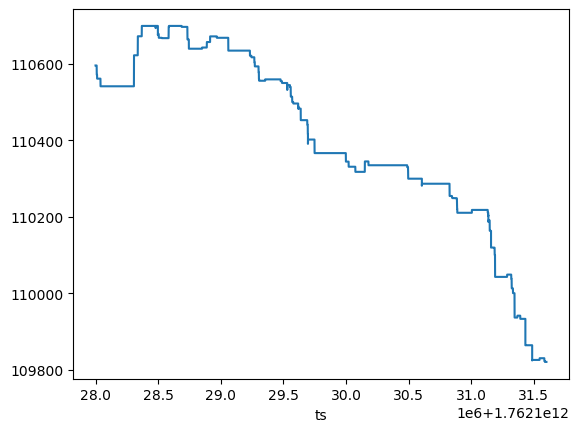

In [20]:
m.plot()

In [21]:
best.tail()

instrument    action side     price      size  \
ts                                                                    
1762131599255 2561250   BTC-USDC  snapshot  bid  109819.9  1.105631   
1762131599445 2561349   BTC-USDC  snapshot  ask  109820.0  0.567487   
              2561350   BTC-USDC  snapshot  bid  109819.9  1.105631   
1762131599865 2561449   BTC-USDC  snapshot  ask  109820.0  0.567487   
              2561450   BTC-USDC  snapshot  bid  109819.9  1.105631   

                                  ts                         timestamp  
ts                                                                      
1762131599255 2561250  1762131599255  2025-11-03 00:59:59.255000+00:00  
1762131599445 2561349  1762131599445  2025-11-03 00:59:59.445000+00:00  
              2561350  1762131599445  2025-11-03 00:59:59.445000+00:00  
1762131599865 2561449  1762131599865  2025-11-03 00:59:59.865000+00:00  
              2561450  1762131599865  2025-11-03 00:59:59.865000+00:00

<Axes: >

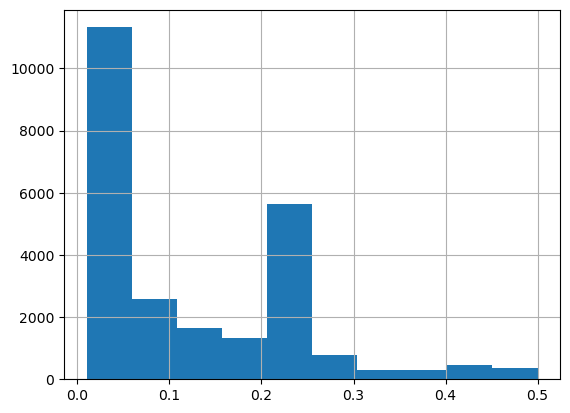

In [22]:
dt = pd.to_datetime(best.index.get_level_values(0), unit='ms').to_series().diff().dt.total_seconds()
dt[dt.between(0.01, 0.5)].hist()

# Other

In [14]:
def rebuild_snapshots_every_100ms(df: pd.DataFrame, freq_ms: int = 100, depth: int | None = None) -> pd.DataFrame:
    """
    Replay OKX order-book snapshots + updates but only emit a synthetic snapshot every `freq_ms`.
    """
    df = df.sort_values(["instrument", "ts", "side", "price"]).reset_index(drop=True)

    output_rows: list[dict] = []

    for instrument, inst_df in df.groupby("instrument"):
        book = {"bid": {}, "ask": {}}
        have_snapshot = False
        next_emit_ts: int | None = None

        for ts, ts_chunk in inst_df.groupby("ts"):
            action = ts_chunk["action"].iloc[0]

            if action == "snapshot":
                book = {"bid": {}, "ask": {}}
                have_snapshot = True
                for side in ("bid", "ask"):
                    side_rows = ts_chunk[ts_chunk["side"] == side]
                    for _, row in side_rows.iterrows():
                        if pd.notna(row["price"]) and pd.notna(row["size"]):
                            book[side][row["price"]] = row["size"]
                next_emit_ts = ts if next_emit_ts is None else max(next_emit_ts, ts)

            elif action == "update" and have_snapshot:
                for _, row in ts_chunk.iterrows():
                    side, price, size = row["side"], row["price"], row["size"]
                    if side not in ("bid", "ask") or pd.isna(price):
                        continue
                    if pd.isna(size) or size == 0:
                        book[side].pop(price, None)
                    else:
                        book[side][price] = size

            else:
                continue  # ignore updates before the first snapshot

            if not have_snapshot:
                continue

            if next_emit_ts is None:
                next_emit_ts = ts

            while next_emit_ts <= ts:
                ts_dt = pd.to_datetime(next_emit_ts, unit="ms", utc=True)
                for side in ("bid", "ask"):
                    levels = sorted(
                        book[side].items(),
                        key=(lambda kv: -kv[0]) if side == "bid" else (lambda kv: kv[0]),
                    )
                    if depth is not None:
                        levels = levels[:depth]
                    for price, size in levels:
                        output_rows.append(
                            {
                                "instrument": instrument,
                                "action": "snapshot",
                                "side": side,
                                "price": price,
                                "size": size,
                                "ts": next_emit_ts,
                                "timestamp": ts_dt,
                            }
                        )
                next_emit_ts += freq_ms

    return (
        pd.DataFrame(output_rows)
        .sort_values(["instrument", "ts", "side", "price"])
        .reset_index(drop=True)
    )

snapshots_100ms = rebuild_snapshots_every_100ms(orderbook_df, freq_ms=100, depth=50)
snapshots_100ms.head()

,instrument,action,side,price,size,ts,timestamp
0,BTC-USDC,snapshot,ask,110596.4,2.829819,1762128000022,2025-11-03 00:00:00.022000+00:00
1,BTC-USDC,snapshot,ask,110598.1,0.004521,1762128000022,2025-11-03 00:00:00.022000+00:00
2,BTC-USDC,snapshot,ask,110615.8,0.558266,1762128000022,2025-11-03 00:00:00.022000+00:00
3,BTC-USDC,snapshot,ask,110625.0,0.000133,1762128000022,2025-11-03 00:00:00.022000+00:00
4,BTC-USDC,snapshot,ask,110625.1,0.271510,1762128000022,2025-11-03 00:00:00.022000+00:00


In [22]:
books = rebuilt_snapshots

In [25]:
books.head()

,instrument,action,side,price,size,ts,timestamp
0,BTC-USDC,snapshot,ask,110596.4,2.829819,1762128000022,2025-11-03 00:00:00.022000+00:00
1,BTC-USDC,snapshot,ask,110598.1,0.004521,1762128000022,2025-11-03 00:00:00.022000+00:00
2,BTC-USDC,snapshot,ask,110615.8,0.558266,1762128000022,2025-11-03 00:00:00.022000+00:00
3,BTC-USDC,snapshot,ask,110625.0,0.000133,1762128000022,2025-11-03 00:00:00.022000+00:00
4,BTC-USDC,snapshot,ask,110625.1,0.271510,1762128000022,2025-11-03 00:00:00.022000+00:00


In [28]:
books[books.ts == 1762128000022].sort_values('price', ascending=False)

,instrument,action,side,price,size,ts,timestamp
49,BTC-USDC,snapshot,ask,111382.9,0.030049,1762128000022,2025-11-03 00:00:00.022000+00:00
48,BTC-USDC,snapshot,ask,111362.8,0.060110,1762128000022,2025-11-03 00:00:00.022000+00:00
47,BTC-USDC,snapshot,ask,111349.9,0.000103,1762128000022,2025-11-03 00:00:00.022000+00:00
46,BTC-USDC,snapshot,ask,111333.3,0.000139,1762128000022,2025-11-03 00:00:00.022000+00:00
45,BTC-USDC,snapshot,ask,111287.0,0.000122,1762128000022,2025-11-03 00:00:00.022000+00:00
...,...,...,...,...,...,...,...
54,BTC-USDC,snapshot,bid,109333.3,0.000268,1762128000022,2025-11-03 00:00:00.022000+00:00
53,BTC-USDC,snapshot,bid,109284.6,0.000152,1762128000022,2025-11-03 00:00:00.022000+00:00
52,BTC-USDC,snapshot,bid,109268.2,0.000722,1762128000022,2025-11-03 00:00:00.022000+00:00
51,BTC-USDC,snapshot,bid,109244.7,0.001177,1762128000022,2025-11-03 00:00:00.022000+00:00


In [19]:
pc = rebuilt_snapshots.groupby('ts').price.unique().apply(lambda a: len(a))

In [35]:
books

,instrument,action,side,price,size,ts,timestamp
0,BTC-USDC,snapshot,ask,111382.9,0.030049,1762128000022,2025-11-03 00:00:00.022000+00:00
1,BTC-USDC,snapshot,ask,111362.8,0.060110,1762128000022,2025-11-03 00:00:00.022000+00:00
2,BTC-USDC,snapshot,ask,111349.9,0.000103,1762128000022,2025-11-03 00:00:00.022000+00:00
3,BTC-USDC,snapshot,ask,111333.3,0.000139,1762128000022,2025-11-03 00:00:00.022000+00:00
4,BTC-USDC,snapshot,ask,111287.0,0.000122,1762128000022,2025-11-03 00:00:00.022000+00:00
...,...,...,...,...,...,...,...
1855795,BTC-USDC,snapshot,bid,109538.4,0.000534,1762130760045,2025-11-03 00:46:00.045000+00:00
1855796,BTC-USDC,snapshot,bid,109500.0,0.000959,1762130760045,2025-11-03 00:46:00.045000+00:00
1855797,BTC-USDC,snapshot,bid,109488.5,0.068053,1762130760045,2025-11-03 00:46:00.045000+00:00
1855798,BTC-USDC,snapshot,bid,109458.3,0.000123,1762130760045,2025-11-03 00:46:00.045000+00:00


In [45]:
best = books.groupby('ts').apply(lambda rs: rs.iloc[[49, 50], :])

/var/folders/rg/924pll9j68bfrh5rd1jf4hl40000gn/T/ipykernel_29661/2057675803.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best = books.groupby('ts').apply(lambda rs: rs.iloc[[49, 50], :])


In [48]:
best

instrument    action side     price      size  \
ts                                                                    
1762128000022 49        BTC-USDC  snapshot  ask  110596.4  2.829819   
              50        BTC-USDC  snapshot  bid  110596.3  1.085510   
1762128000162 149       BTC-USDC  snapshot  ask  110596.4  2.829819   
              150       BTC-USDC  snapshot  bid  110596.3  1.085510   
1762128000382 249       BTC-USDC  snapshot  ask  110596.4  2.829819   
...                          ...       ...  ...       ...       ...   
1762130759945 1855550   BTC-USDC  snapshot  bid  110286.6  2.285435   
1762130759955 1855649   BTC-USDC  snapshot  ask  110286.7  2.267336   
              1855650   BTC-USDC  snapshot  bid  110286.6  2.285435   
1762130760045 1855749   BTC-USDC  snapshot  ask  110286.7  2.267336   
              1855750   BTC-USDC  snapshot  bid  110286.6  2.285435   

                                  ts                         timestamp  
ts                                                                      
1762128000022 49       1762128000022  2025-11-03 00:00:00.022000+00:00  
              50       1762128000022  2025-11-03 00:00:00.022000+00:00  
1762128000162 149      1762128000162  2025-11-03 00:00:00.162000+00:00  
              150      1762128000162  2025-11-03 00:00:00.162000+00:00  
1762128000382 249      1762128000382  2025-11-03 00:00:00.382000+00:00  
...                              ...                               ...  
1762130759945 1855550  1762130759945  2025-11-03 00:45:59.945000+00:00  
1762130759955 1855649  1762130759955  2025-11-03 00:45:59.955000+00:00  
              1855650  1762130759955  2025-11-03 00:45:59.955000+00:00  
1762130760045 1855749  1762130760045  2025-11-03 00:46:00.045000+00:00  
              1855750  1762130760045  2025-11-03 00:46:00.045000+00:00  

[37116 rows x 7 columns]

In [51]:
m = best.groupby(level=0).price.mean()

<Axes: xlabel='ts'>

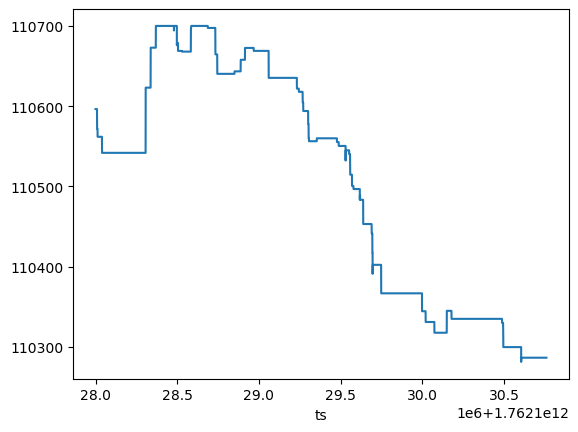

In [81]:
m.plot()

In [ ]:
dt = pd.to_datetime(best.index.get_level_values(0), unit='ms').to_series().diff().dt.total_seconds()
dt[dt.between(0.01, 0.5)].hist()

In [ ]:
pd.summary

In [ ]:
pd.to_datetime()